In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from matplotlib.colors import LogNorm
from featurizers.morgan import ECFP6
from sklearn.decomposition import PCA
from kmeans import get_centroids, get_cluster_id


In [2]:
feat_name = 'morgan'

In [3]:
# dataset and featurization
qm9 = pd.read_csv('data/qm9.csv') # qm9 dataset
qm9['gap'] = qm9['gap']*27.2114
if feat_name == 'morgan':
    feat = pd.read_csv(f'data/{feat_name}/qm9_ECFP6.csv') # morgan fingerprints
elif feat_name == 'molformer':
    feat = pd.read_csv(f'data/{feat_name}/qm9_molformer.csv')


# col names
prop_cols = ['A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap',
       'r2', 'zpve', 'u0', 'u298', 'h298', 'g298', 'cv', 'u0_atom',
       'u298_atom', 'h298_atom', 'g298_atom']
feat_cols = [f'bit{i}' for i in range(2048)]

# combine features with dataset
for col in prop_cols:
    feat[col] = qm9[col]

# PCA 
pca = PCA(n_components=2)
feat_pca = pca.fit_transform(feat[feat_cols])
feat['PCA 1'], feat['PCA 2']  = feat_pca[:,0], feat_pca[:,1]

<Figure size 432x288 with 0 Axes>

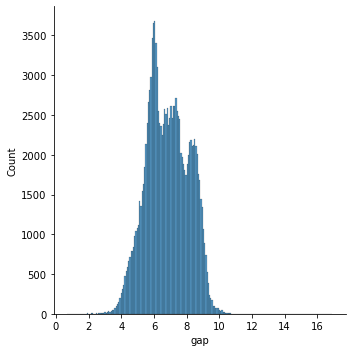

In [4]:
plt.figure()
sns.displot(feat['gap'])

No handles with labels found to put in legend.


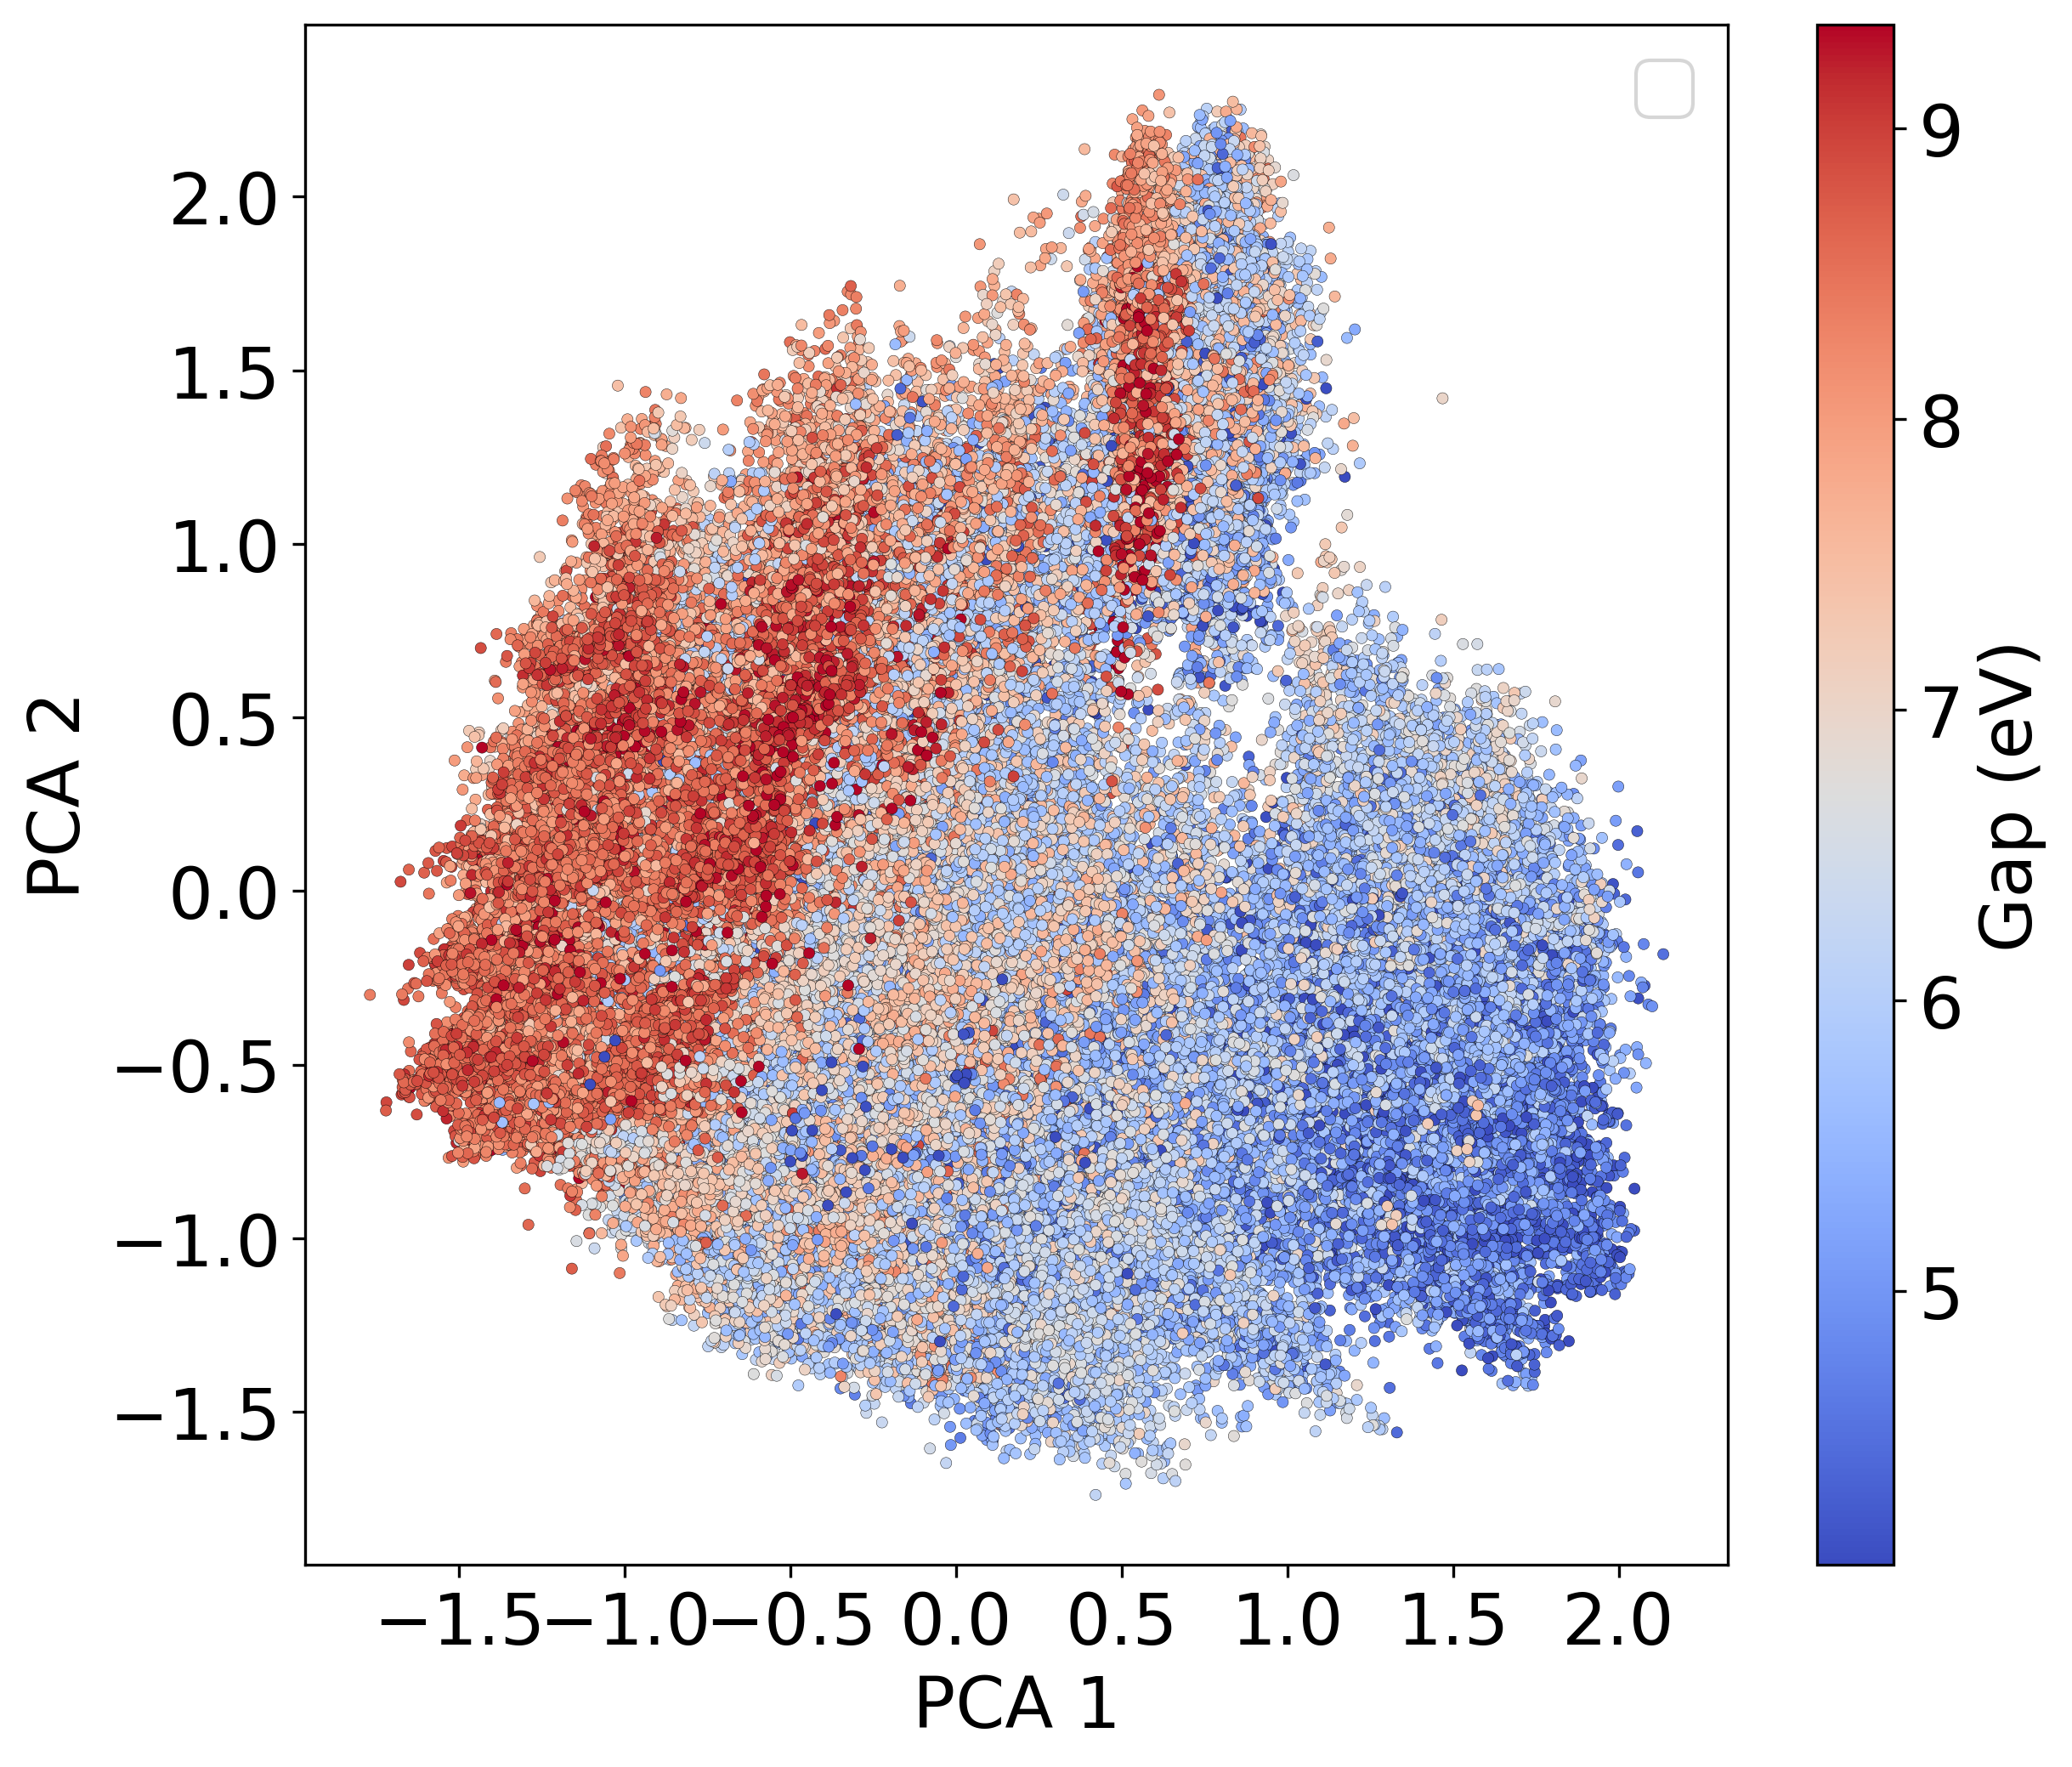

In [5]:
fig = plt.figure(figsize=(9,8), dpi=300)
plt.scatter(feat['PCA 1'], feat['PCA 2'], 
            # c=feat['gap'], 
            c=feat['gap'],
            marker='o', s=10, cmap='coolwarm', linewidth=0.1, edgecolors='black', alpha=1.,
            # norm=LogNorm(),
            vmin=np.quantile(feat['gap'], 0.01), vmax=np.quantile(feat['gap'], 0.99),
            )

cb = plt.colorbar()
cb.set_label(label='Gap (eV)', size=20)
cb.ax.tick_params(labelsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('PCA 1', fontsize=20)
plt.ylabel('PCA 2', fontsize=20)
plt.legend(fontsize=20)

plt.show()

In [6]:
# mask out bottom 40% of gaps
percentile = 0.4
feat_masked = feat[feat['gap'] > np.quantile(feat['gap'], percentile)]
feat_masked

smiles  bit0  bit1  bit2  bit3  bit4  bit5  bit6  bit7  \
0                         C     0     0     0     0     0     0     0     0   
1                         N     0     0     0     0     0     0     0     0   
2                         O     0     0     0     0     0     0     0     0   
3                       C#C     0     0     0     0     0     0     0     0   
4                       C#N     0     0     0     0     0     0     0     0   
...                     ...   ...   ...   ...   ...   ...   ...   ...   ...   
133880  C1C2C3C4C5OC14C5N23     0     0     0     0     0     0     0     0   
133881  C1N2C3C2C2C4OC12C34     0     0     0     0     0     1     0     0   
133882  C1N2C3C4C5C2C13CN45     0     0     0     0     0     1     0     0   
133883  C1N2C3C4C5CC13C2C45     0     0     0     0     0     1     0     0   
133884  C1N2C3C4C5OC13C2C45     0     0     0     0     0     1     0     0   

        bit8  ...        u298        h298        g298      cv      u0_atom  \
0          0  ...  -40.476062  -40.475117  -40.498597   6.469  -395.999595   
1          0  ...  -56.523026  -56.522082  -56.544961   6.316  -276.861363   
2          0  ...  -76.401867  -76.400922  -76.422349   6.002  -213.087624   
3          0  ...  -77.305527  -77.304583  -77.327429   8.574  -385.501997   
4          0  ...  -93.409370  -93.408425  -93.431246   6.278  -301.820534   
...      ...  ...         ...         ...         ...     ...          ...   
133880     0  ... -400.628599 -400.627654 -400.663098  23.658 -1603.983913   
133881     0  ... -400.624444 -400.623500 -400.658942  23.697 -1601.376613   
133882     0  ... -380.748619 -380.747675 -380.783148  23.972 -1667.045429   
133883     0  ... -364.714974 -364.714030 -364.749650  24.796 -1794.600439   
133884     0  ... -400.627892 -400.626948 -400.662186  23.434 -1603.471865   

          u298_atom    h298_atom    g298_atom     PCA 1     PCA 2  
0       -398.643290  -401.014647  -372.471772  0.401307  0.180424  
1       -278.620271  -280.399259  -259.338802  0.401359  0.181058  
2       -213.974294  -215.159658  -201.407171  0.389900  0.322526  
3       -387.237686  -389.016047  -365.800724  0.405019  0.280096  
4       -302.906752  -304.091489  -288.720028  0.418164  0.407055  
...             ...          ...          ...       ...       ...  
133880 -1614.898804 -1623.788097 -1492.819438 -1.209245 -0.344011  
133881 -1612.291504 -1621.181424 -1490.211511 -1.042001 -0.549166  
133882 -1678.830048 -1688.312964 -1549.143391 -0.779642 -0.275915  
133883 -1807.210860 -1817.286772 -1670.349892 -0.976397 -0.314236  
133884 -1614.455155 -1623.345075 -1492.247150 -1.013845 -0.587159  

[80282 rows x 2070 columns]

In [7]:
# random splits
n_seeds = 10
n_samples = [5, 10, 20, 50, 100, 200]
for n_sample in n_samples:
    for seed in range(n_seeds):
        feat_masked.sample(n_sample, random_state=seed).to_csv(f'data/{feat_name}/splits/random/warmup_n{n_sample}_s{seed}.csv', index=False)

In [8]:
# get centroids and cluster ids for each point
n_centroids = 5
centroids = get_centroids(data=feat_masked[['PCA 1', 'PCA 2']], num_centroids=n_centroids)
cluster_ids = get_cluster_id(feat_masked[['PCA 1', 'PCA 2']], centroids) 
feat_masked['cluster_id'] = cluster_ids

100%|██████████| 80282/80282 [00:02<00:00, 37427.77it/s]
/home/synthesisproject/anaconda3/envs/bayes-warmup/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [9]:
# fragment split
for n_sample in n_samples:
    for cluster_id in range(n_centroids):
        feat_masked_frag = feat_masked[feat_masked['cluster_id'] == cluster_id]
        for seed in range(n_seeds):
            feat_masked_frag.sample(n_sample, random_state=seed).to_csv(f'data/{feat_name}/splits/fragment/warmup_n{n_sample}_c{cluster_id}_s{seed}.csv', index=False)

In [10]:
# stratified split
assert n_sample%n_centroids == 0, 'n_sample must be divisible by n_centroids'
for n_sample in n_samples:
    for seed in range(n_seeds):
        stratified_samples = []
        for cluster_id in range(n_centroids):
            samples = feat_masked[feat_masked['cluster_id'] == cluster_id].sample(int(n_sample/n_centroids), random_state=seed)
            stratified_samples.append(samples)
        stratified_samples = pd.concat(stratified_samples)
        stratified_samples.to_csv(f'data/{feat_name}/splits/stratified/warmup_n{n_sample}_s{seed}.csv', index=False)


In [11]:
stratified_samples

smiles  bit0  bit1  bit2  bit3  bit4  bit5  bit6  bit7  \
133765   OCC1(CN1)C(F)(F)F     0     0     0     0     0     0     0     0   
55722    C1CC1(C#N)NC(=O)N     0     0     0     0     0     0     0     0   
104746      CCC1(CC1C#N)OC     0     0     0     0     0     0     0     0   
54404   NC(=O)C12CC(C1)CC2     1     0     0     0     0     0     0     0   
68078    CC12CC(O)(C1)CCC2     0     0     0     0     0     0     0     0   
...                    ...   ...   ...   ...   ...   ...   ...   ...   ...   
88200        CC1NC11COCOC1     0     0     0     0     0     0     0     0   
90263      OC1CC23CCC2CC13     0     0     0     0     0     0     0     0   
33767    N#CC12CC(C1)C=CC2     0     0     0     0     0     0     0     0   
33745   C#CC12CC(C1)C21CC1     0     0     0     0     0     0     0     0   
40716    C1CN1C1CC2(CO2)C1     0     0     0     0     0     0     0     0   

        bit8  ...        h298        g298      cv      u0_atom    u298_atom  \
133765     0  ... -585.410156 -585.453456  31.232 -1397.033327 -1404.985121   
55722      0  ... -434.092556 -434.137236  33.246 -1600.595991 -1609.076148   
104746     0  ... -403.136521 -403.182604  36.222 -1925.614905 -1937.085770   
54404      0  ... -403.170355 -403.213056  32.333 -1945.763592 -1958.316910   
68078      0  ... -388.294606 -388.336362  35.558 -2172.166329 -2187.213367   
...      ...  ...         ...         ...     ...          ...          ...   
88200      0  ... -440.248907 -440.290906  32.004 -1858.364766 -1870.932516   
90263      0  ... -387.035510 -387.077227  32.211 -2009.571217 -2023.194438   
33767      0  ... -364.820947 -364.860375  29.209 -1862.807530 -1874.302240   
33745      0  ... -348.644586 -348.685583  32.250 -1901.225513 -1913.127476   
40716      0  ... -403.067792 -403.110320  32.041 -1881.377404 -1893.957704   

          h298_atom    g298_atom     PCA 1     PCA 2  cluster_id  
133765 -1413.282045 -1294.905610 -0.641535  0.492795           0  
55722  -1617.966068 -1492.178124 -0.128976  0.999852           0  
104746 -1948.347674 -1791.386965 -0.815410  1.171004           0  
54404  -1969.578814 -1810.495869 -0.771366  0.188835           0  
68078  -2200.254259 -2016.384710 -0.708070  0.409384           0  
...             ...          ...       ...       ...         ...  
88200  -1882.194420 -1722.415569 -0.937907 -0.575761           4  
90263  -2035.048710 -1867.488747 -1.411602  0.144542           4  
33767  -1884.378152 -1739.830826 -0.707537  0.052818           4  
33745  -1923.796384 -1772.374070 -1.037696  0.222027           4  
40716  -1905.219608 -1746.028105 -0.881759 -0.729196           4  

[200 rows x 2071 columns]

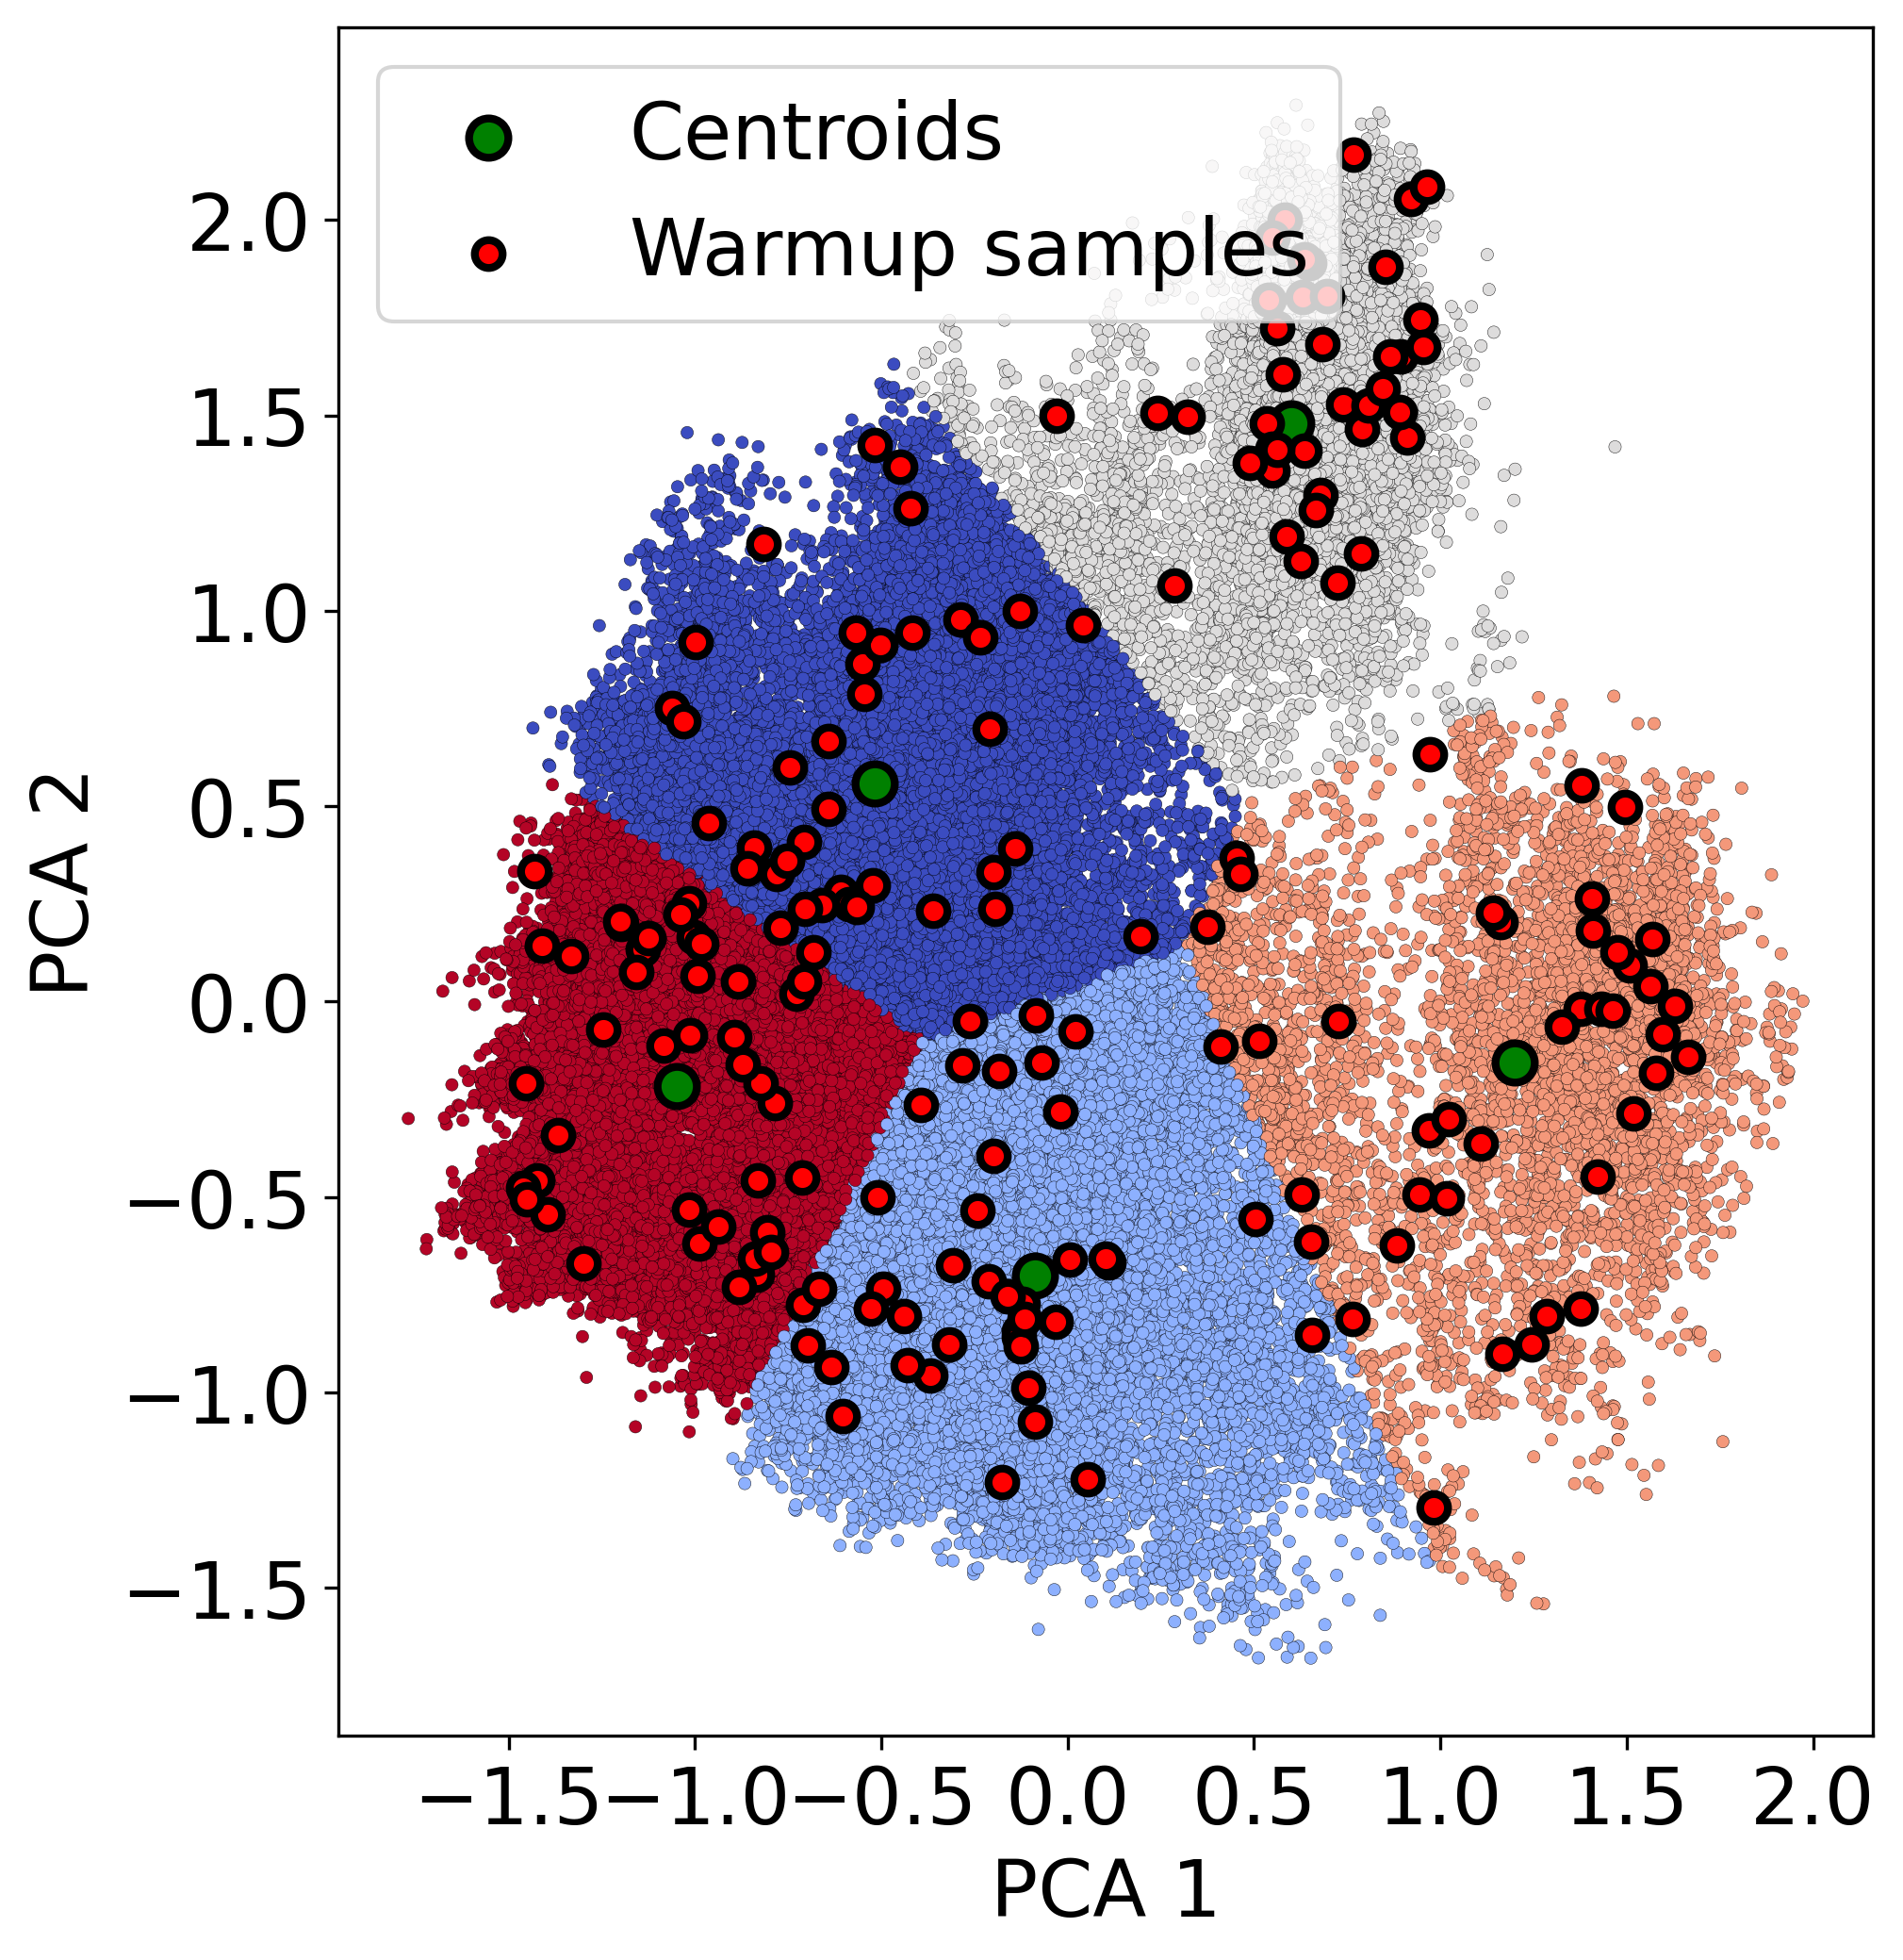

In [12]:
fig = plt.figure(figsize=(7,8), dpi=300)
plt.scatter(feat_masked['PCA 1'], feat_masked['PCA 2'], 
            c=feat_masked['cluster_id'],
            marker='o', s=10, cmap='coolwarm', linewidth=0.1, edgecolors='black', alpha=1.,
            )

plt.scatter(centroids[:,0], centroids[:,1], 
            c='g', 
            marker='o', s=100, label='Centroids', cmap='coolwarm', linewidth=2, edgecolors='black', alpha=1,
            )
plt.scatter(stratified_samples['PCA 1'], stratified_samples['PCA 2'], 
            c='r', 
            marker='o', s=50, label='Warmup samples', linewidth=2, edgecolors='black', alpha=1,
            )

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('PCA 1', fontsize=20)
plt.ylabel('PCA 2', fontsize=20)
plt.legend(fontsize=20)

plt.show()